In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle_api"   # folder path

In [3]:
%mkdir /content/data
%cd /content/data

/content/data


In [4]:
! kaggle datasets download -d ahmedhaytham/where-am-i

100% 4.06G/4.06G [00:27<00:00, 182MB/s]
100% 4.06G/4.06G [00:27<00:00, 161MB/s]


In [5]:
%%capture --no-display
! unzip /content/data/where-am-i.zip;

In [6]:
training_dir = '/content/data/Data/train'
testing_dir = '/content/data/Data/test'
validation_dir = '/content/data/Data/Val'

In [7]:
BATCH_SIZE = 64
IMAGE_SIZE = 200
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_dir,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    testing_dir,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE ,
)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE ,
  
)

Found 1800 files belonging to 3 classes.
Found 600 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [8]:
class_names = train_dataset.class_names
class_names

['cairo', 'moscow', 'paris']

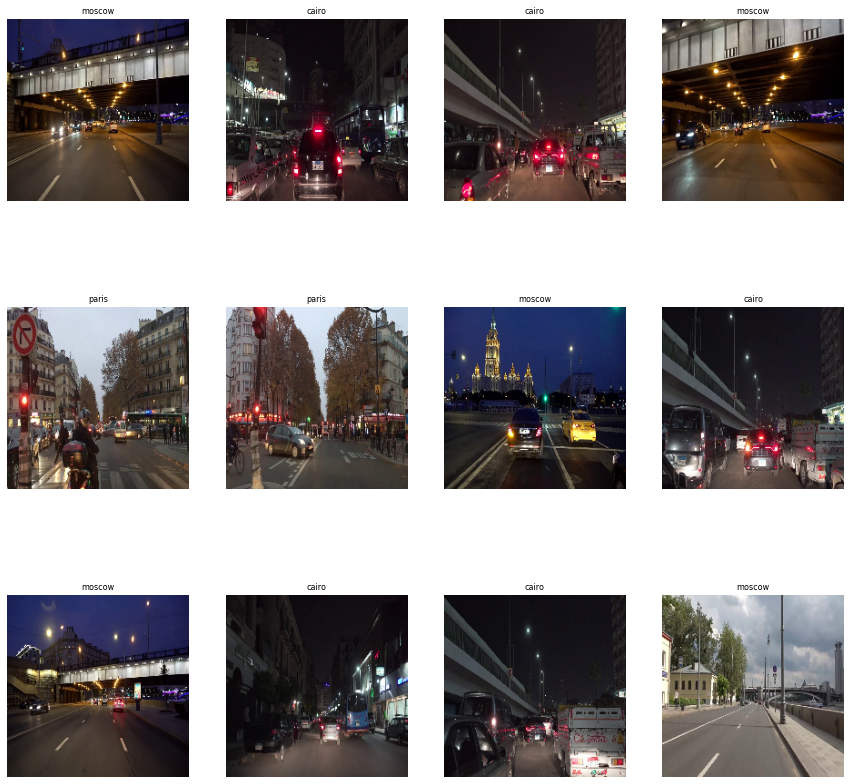

In [9]:
 plt.figure(figsize = (15,15))
 for image_batch, label_batch in train_dataset.take(1):
   for i in range(12):
     ax = plt.subplot(3,4,i+1)
     plt.imshow(image_batch[i].numpy().astype("uint8"))
     plt.title(class_names[label_batch[i]],fontsize = 8)
     plt.axis("off")
  #  print(image_batch.shape[0].shape)

In [10]:
# data aug
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

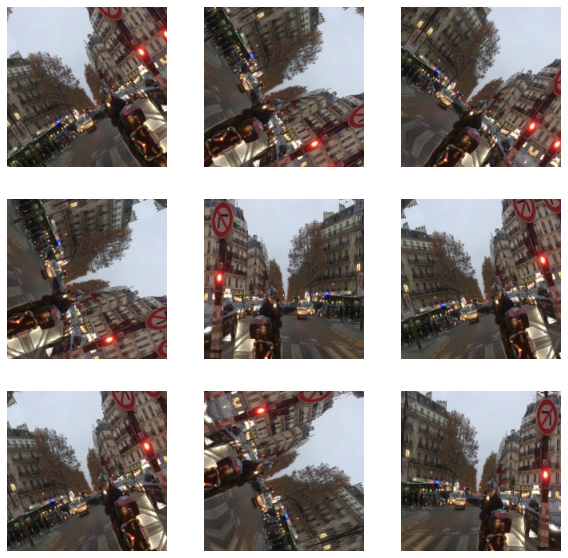

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Feature extraction

In [36]:
# Res Net 50
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')


In [37]:
base_model.trainable = False

In [38]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [47]:
model= tf.keras.Sequential([
                            base_model,
                            tf.keras.layers.GlobalAveragePooling2D(),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(2048, activation='relu'),
                            tf.keras.layers.Dense(1000, activation='relu'),
                            tf.keras.layers.Dense(500, activation='relu'),
                            tf.keras.layers.Dense(200, activation='relu'),
                            tf.keras.layers.Dense(100, activation='relu'),
                            tf.keras.layers.Dense(50, activation='relu'),
                            tf.keras.layers.Dense(25, activation='relu'),
                            tf.keras.layers.Dense(3, activation='softmax'),

])

In [48]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_10 (Flatten)        (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_19 (Dense)            (None, 1000)              2049000   
                                                                 
 dense_20 (Dense)            (None, 500)               500500    
                                                     

In [49]:
model.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [50]:
EPOCHS = 3
history6 = model.fit(
    train_dataset,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = val_dataset,
    verbose = 1,
) 

Epoch 1/3
29/29 [==============================] - 15s 344ms/step - loss: 0.4221 - accuracy: 0.8439 - val_loss: 0.0401 - val_accuracy: 0.9867
Epoch 2/3
29/29 [==============================] - 11s 318ms/step - loss: 0.0110 - accuracy: 0.9961 - val_loss: 1.3330 - val_accuracy: 0.6633
Epoch 3/3
29/29 [==============================] - 11s 317ms/step - loss: 0.0059 - accuracy: 0.9972 - val_loss: 0.0682 - val_accuracy: 0.9800


In [51]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

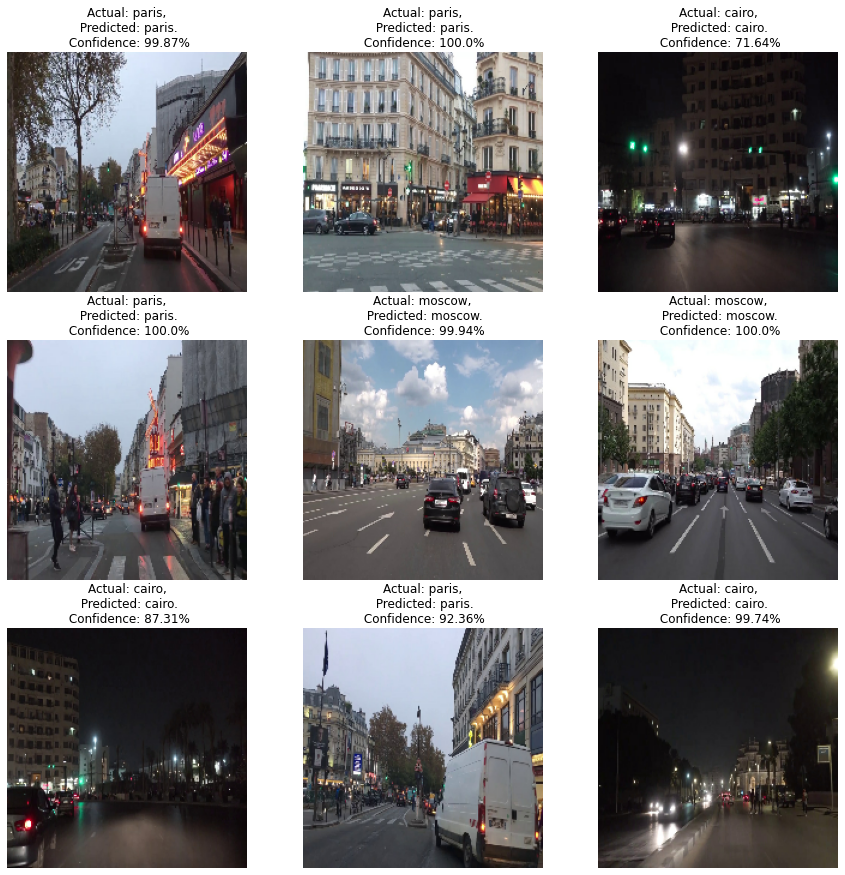

In [56]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Fine tuning

In [58]:
# Do you remember this line?
# Make it True
# repet the past cells
base_model.trainable = False 

# use some of CNN from resnet 50

In [64]:
base_model.layers[0].trainable='What you need True or False'

# we can handle this with loop like

res_name = []
for layer in base_model.layers:
    res_name.append(layer.name)

set_trainable = False
for layer in base_model.layers:
    if layer.name in res_name[-22:]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# End of Project

# want bulid the TL models from scratch ?
go to this repo
https://github.com/moelgendy/deep_learning_for_vision_systems/tree/master/chapter_05